# VQA Project

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
import numpy as np
import math
from typing import Optional, Tuple, Union
import re
import torch
import torch.utils.checkpoint
from torch import nn
from torch.nn import CrossEntropyLoss
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers.activations import ACT2FN, gelu
from transformers.modeling_outputs import (
    BaseModelOutputWithPastAndCrossAttentions,
    BaseModelOutputWithPoolingAndCrossAttentions,
    CausalLMOutputWithCrossAttentions,
)
from transformers.modeling_utils import PreTrainedModel
from transformers import RobertaConfig, RobertaForMaskedLM
from transformers import AutoTokenizer, AutoImageProcessor, ViTModel, RobertaModel
import torchtext
from vqa import VQA
import os
from torchvision.io import read_image, ImageReadMode
from tqdm.notebook import tqdm
from einops import rearrange
from torch import optim
import pickle
import copy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import vqaEval

In [69]:
import shutil

In [2]:
torch.cuda.get_device_name()

'Tesla V100-SXM2-16GB'

## Data Import and Processing

In [3]:
annfiletrain = '../Data/v2_mscoco_train2014_annotations.json'
quesfiletrain = '../Data/v2_OpenEnded_mscoco_train2014_questions.json'

In [4]:
vqadata = VQA(annfiletrain, quesfiletrain)

loading VQA annotations and questions into memory...
0:00:12.101017
creating index...
index created!


In [5]:
VQAData = {}
for key in vqadata.qa.keys():
    VQAData[key] = {}
    VQAData[key]['image_id'] = vqadata.qqa[key]['image_id']
    VQAData[key]['question'] = vqadata.qqa[key]['question']
    VQAData[key]['answer'] = vqadata.qa[key]['multiple_choice_answer']

In [6]:
print(len(VQAData.keys()))


443757


In [7]:
for val in VQAData.values():
    print(val)
    break

{'image_id': 458752, 'question': 'What is this photo taken looking through?', 'answer': 'net'}


In [8]:
vqadata = None

In [9]:
annfileval = '../Data/v2_mscoco_val2014_annotations.json'
quesfileval = '../Data/v2_OpenEnded_mscoco_val2014_questions.json'
vqaval = VQA(annfileval, quesfileval)

loading VQA annotations and questions into memory...
0:00:03.733720
creating index...
index created!


In [10]:
VQAVal = {}
for key in vqaval.qa.keys():
    VQAVal[key] = {}
    VQAVal[key]['image_id'] = vqaval.qqa[key]['image_id']
    VQAVal[key]['question'] = vqaval.qqa[key]['question']
    VQAVal[key]['answer'] = vqaval.qa[key]['multiple_choice_answer']

In [11]:
print(len(VQAVal.keys()))


214354


In [12]:
for val in VQAVal.values():
    print(val)
    break

{'image_id': 262148, 'question': 'Where is he looking?', 'answer': 'down'}


In [13]:
vqaval = None

In [13]:
vocabAns = torchtext.vocab.build_vocab_from_iterator([[val['answer']] for val in VQAData.values()], 
min_freq=6, max_tokens=3000)       
vocabAns.set_default_index(2999)   
print(len(vocabAns))                         
# print(vocabAns.get_itos()[1015:])   

3000


In [16]:
vocabAns.lookup_token(0)

'yes'

In [56]:
count = 0
for val in VQAVal.values():
    if vocabAns[val['answer']] == 2999:
        count += 1
print((count/len(VQAVal))*100)

7.647163104024185


In [14]:
quesIDs = list(VQAData.keys())
len(quesIDs)

443757

In [15]:
VQAData[quesIDs[0]]

{'image_id': 458752,
 'question': 'What is this photo taken looking through?',
 'answer': 'net'}

In [16]:
data_size = {
    'train': len(VQAData),
    'val': len(VQAVal)
}

In [17]:
quesIDsval = list(VQAVal.keys())
len(quesIDsval)

214354

In [18]:
max_ques_length = 40

In [19]:
VQAVal[quesIDsval[0]]

{'image_id': 262148, 'question': 'Where is he looking?', 'answer': 'down'}

In [79]:
for name in tqdm(os.listdir('../Data/val2014')):
    # print(name)
    # print(name[13:-4])
    id = int(name[13:-4])
    # print(id)
    src = '../Data/val2014/' + name
    dst = f'../Data/val2014/{id}.jpg'
    os.rename(src, dst)

  0%|          | 0/40504 [00:00<?, ?it/s]

In [106]:
# for name in tqdm(os.listdir('../Data/train2014')):
#     id = int(name[15:-4])
#     src = '../Data/train2014/' + name
#     dst = f'../Data/train2014/{id}.jpg'
#     os.rename(src, dst)

  0%|          | 0/82783 [00:00<?, ?it/s]

In [20]:
model_name_or_path = 'google/vit-base-patch16-224-in21k'
imgprocessor = AutoImageProcessor.from_pretrained(model_name_or_path)
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

In [21]:
class VQADataset(Dataset):
  def __init__(self, data, qids, train=False):

    super(VQADataset, self).__init__()
    self.data_dict = data
    self.qids = qids
    self.folder = 'val2014'
    if train:
        self.folder = 'train2014'
    
  def __len__(self):

    return len(self.qids)
  
  def __getitem__(self, index):
    
    label = torch.tensor(vocabAns[self.data_dict[self.qids[index]]['answer']], dtype=torch.long)
    qid = torch.tensor(self.qids[index], dtype=torch.long)
    image = read_image(f'../Data/{self.folder}/{self.data_dict[self.qids[index]]["image_id"]}.jpg', mode=ImageReadMode.RGB)
    inp1 = imgprocessor(image, return_tensors='pt')
    inp2 = tokenizer(self.data_dict[self.qids[index]]['question'], return_tensors='pt', padding='max_length', max_length=max_ques_length, add_special_tokens=True, truncation=True)
    return {
        'px': inp1['pixel_values'].squeeze(0),
        'ids': inp2['input_ids'].squeeze(0),
        'mask': inp2['attention_mask'].squeeze(0),
        'qid': qid,
        'label': label
    }

    

BATCH_SIZE = 32

dataTrain = VQADataset(data=VQAData, qids=quesIDs, train=True)
dataVal = VQADataset(data=VQAVal, qids=quesIDsval)

dataloader = {
    'train': DataLoader(dataset= dataTrain, batch_size=BATCH_SIZE, shuffle=True, num_workers=4),
    'val': DataLoader(dataset= dataVal, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
}

In [ ]:
for inputs in tqdm(dataloader['train']):
    pass

## Model


### Vision Encoder

In [22]:
# customised LayerNorm
class LayerNorm(nn.LayerNorm):
    # We always use float32 for the LayerNorm for stable training
    def forward(self, x: torch.Tensor):
        orig_type = x.dtype
        ret = F.layer_norm(x.to(torch.float32), self.normalized_shape, self.weight.to(torch.float32), self.bias.to(torch.float32), self.eps)
        return ret.type(orig_type)


# activations
class QuickGELU(nn.Module):
    def forward(self, x: torch.Tensor):
        return x * torch.sigmoid(1.702 * x)


class SquaredReLU(nn.Module):
    def forward(self, x: torch.Tensor):
        return torch.square(torch.relu(x))


# interpolate position embedding
def interpolate_pos_embed(orig_pos_embed, target_len):
    orig_size = int((orig_pos_embed.shape[0]) ** 0.5)
    new_size = int(target_len ** 0.5)

    if orig_size != new_size:
        orig_pos_embed = orig_pos_embed.reshape(1, orig_size, orig_size, -1).permute(0, 3, 1, 2)
        orig_pos_embed = F.interpolate(orig_pos_embed, size=(new_size, new_size), mode='bicubic', align_corners=False)
        orig_pos_embed = orig_pos_embed.permute(0, 2, 3, 1).flatten(0, 2)
        return orig_pos_embed
    else:
        return orig_pos_embed


# Adaptor design
class Adaptor(nn.Module):
    def __init__(self, embed_dim: int, norm_late=False):
        super().__init__()
        self.norm_late = norm_late
        self.adaptor = nn.Sequential(OrderedDict([
                ("down_proj", nn.Linear(embed_dim, embed_dim // 1)),
                ("sq_relu", SquaredReLU()),
                ("up_proj", nn.Linear(embed_dim // 1, embed_dim))
            ])
        )
        self.adaptor_ln = LayerNorm(embed_dim)

    def forward(self, hidden_states: torch.Tensor):
        if self.norm_late:
            hidden_states = self.adaptor_ln(self.adaptor(hidden_states) + hidden_states)
        else:
            hidden_states = self.adaptor(self.adaptor_ln(hidden_states)) + hidden_states
        return hidden_states

In [23]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

In [24]:
class ResidualAttentionBlock(nn.Module):
    def __init__(self, d_model: int, n_head: int):
        super().__init__()

        self.attn = nn.MultiheadAttention(d_model, n_head)
        self.mlp = nn.Sequential(OrderedDict([
                ("c_fc", nn.Linear(d_model, d_model * 4)),
                ("gelu", QuickGELU()),
                ("c_proj", nn.Linear(d_model * 4, d_model))
            ])
        )

        self.ln_1 = LayerNorm(d_model)
        self.ln_2 = LayerNorm(d_model)

    def attention(self, x: torch.Tensor):
        return self.attn(x, x, x, need_weights=False)[0]

    def forward(self, x: torch.Tensor, mode='attention'):
        if mode == 'attention':
            return x + self.attention(self.ln_1(x))
        elif mode == 'mlp':
            return x + self.mlp(self.ln_2(x))


class Transformer(nn.Module):
    def __init__(self, width: int, layers: int, heads: int):
        super().__init__()
        self.resblocks = nn.Sequential(*[nn.ModuleList([
            ResidualAttentionBlock(width, heads), 
            Adaptor(width),
        ]) for _ in range(layers)])

    def forward(self, x: torch.Tensor):
        for resblock, adaptor in self.resblocks:
            x = resblock(x, mode='attention')
            x = adaptor(x)
            x = resblock(x, mode='mlp')
        return x

In [25]:
class Encoder(nn.Module):
  def __init__(self, chw=(3, 224, 224), n_patches=14, hidden_size=768, layers=12, heads=12):
    # Super constructor
    super(Encoder, self).__init__()

    # Attributes
    self.chw = chw # (C, H, W)
    self.n_patches = n_patches
    self.hidden = hidden_size
    self.layers = layers
    self.heads = heads
    self.patch_size = (chw[1] // n_patches, chw[2] // n_patches)
    self.embed_proj = nn.Conv2d(self.chw[0], self.hidden, kernel_size=(self.patch_size[0], self.patch_size[1]), stride=(self.patch_size[0], self.patch_size[1]))
    self.class_token = nn.Parameter(torch.rand(1, self.hidden))

    # 3) Positional embedding
    # self.pos_embed = nn.Parameter(torch.tensor(get_positional_embeddings(self.n_patches ** 2 + 1, self.hidden)))
    self.pos_embed = nn.Parameter(torch.randn((197, 768)))
    self.pos_embed.requires_grad = False
    self.transformer = Transformer(self.hidden, self.layers, self.heads)
    self.ln_pre = LayerNorm(self.hidden)
    self.ln_post = LayerNorm(self.hidden)

  def forward(self, images):
    patches = self.embed_proj(images)
    tokens = patches.view(patches.shape[0], patches.shape[1], -1).transpose(1, 2)

    # Adding classification token to the tokens
    tokens = torch.stack([torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))])

    # Adding positional embedding
    pos_embed = self.pos_embed.repeat(images.shape[0], 1, 1)
    encoder_input = tokens + pos_embed
    encoder_input = encoder_input.transpose(0, 1)
    x = self.ln_pre(encoder_input)
    x = self.transformer(x)
    x = self.ln_post(x)
    return x

### Roberta Decoder


In [26]:
config = {
    'vocab_size': 50265,
    'hidden_size': 768,
    'max_position_embeddings': 514,
    'type_vocab_size': 1,
    'layer_norm_eps': 1e-5,
    'hidden_dropout_prob': 0.1,
    'num_attention_heads': 12,
    'vision_hidden_size': 768,
    'attention_probs_dropout_prob': 0.1,
    'intermediate_size': 768*4,
    'hidden_act': 'gelu',
    'num_hidden_layers': 12,
    'pad_token_id': 1
}

In [27]:
config = RobertaConfig().from_dict(config)

In [28]:
# Copyright (c) 2023, NVIDIA Corporation & Affiliates. All rights reserved.
#
# This work is made available under the Nvidia Source Code License-NC.
# To view a copy of this license, visit
# https://github.com/NVlabs/prismer/blob/main/LICENSE
# Modified from: https://github.com/huggingface/transformers/blob/main/src/transformers/models/roberta/modeling_roberta.py


# from model.modules.utils import LayerNorm, Adaptor

_CHECKPOINT_FOR_DOC = "roberta-base"
_CONFIG_FOR_DOC = "RobertaConfig"
_TOKENIZER_FOR_DOC = "RobertaTokenizer"

ROBERTA_PRETRAINED_MODEL_ARCHIVE_LIST = [
    "roberta-base",
    "roberta-large",
]


def create_position_ids_from_input_ids(input_ids, padding_idx, past_key_values_length=0):
    """
    Replace non-padding symbols with their position numbers. Position numbers begin at padding_idx + 1. Padding symbols
    are ignored. This is modified from fairseq's `utils.make_positions`.
    """
    mask = input_ids.ne(padding_idx).int()
    incremental_indices = (torch.cumsum(mask, dim=1).type_as(mask) + past_key_values_length) * mask
    return incremental_indices.long() + padding_idx


class RobertaEmbeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.word_embeddings = nn.Embedding(config.vocab_size, config.hidden_size, padding_idx=config.pad_token_id)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        self.token_type_embeddings = nn.Embedding(config.type_vocab_size, config.hidden_size)

        self.LayerNorm = LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

        self.register_buffer("position_ids", torch.arange(config.max_position_embeddings).expand((1, -1)))
        self.register_buffer(
            "token_type_ids", torch.zeros(self.position_ids.size(), dtype=torch.long), persistent=False
        )

        self.padding_idx = config.pad_token_id
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size, padding_idx=self.padding_idx)

    def forward(self, input_ids=None):
        position_ids = create_position_ids_from_input_ids(input_ids, self.padding_idx)
        token_type_ids = torch.zeros(input_ids.size(), dtype=torch.long, device=self.position_ids.device)
        inputs_embeds = self.word_embeddings(input_ids)
        token_type_embeddings = self.token_type_embeddings(token_type_ids)

        embeddings = inputs_embeds + token_type_embeddings
        embeddings += self.position_embeddings(position_ids)
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings


class RobertaSelfAttention(nn.Module):
    def __init__(self, config, is_cross_attention=False):
        super().__init__()
        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        if is_cross_attention:
            self.key = nn.Linear(config.vision_hidden_size, self.all_head_size)
            self.value = nn.Linear(config.vision_hidden_size, self.all_head_size)
        else:
            self.key = nn.Linear(config.hidden_size, self.all_head_size)
            self.value = nn.Linear(config.hidden_size, self.all_head_size)
        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

    def forward(self,
                hidden_states: torch.Tensor,
                attention_mask: Optional[torch.FloatTensor] = None,
                encoder_hidden_states: Optional[torch.FloatTensor] = None
                ) -> torch.Tensor:

        q = self.query(hidden_states)

        if encoder_hidden_states is not None:
            k, v = self.key(encoder_hidden_states), self.value(encoder_hidden_states)
        else:
            k, v = self.key(hidden_states), self.value(hidden_states)

        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.num_attention_heads), (q, k, v))

        attention_scores = torch.matmul(q, k.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)

        if attention_mask is not None:
            attention_scores = attention_scores + attention_mask
            attention_scores = torch.max(attention_scores, torch.tensor(torch.finfo(attention_scores.dtype).min))

        # Normalize the attention scores to probabilities.
        if attention_scores.dtype == torch.float16:
            attention_probs = torch.softmax(attention_scores, dim=-1, dtype=torch.float32).to(attention_scores.dtype)
        else:
            attention_probs = torch.softmax(attention_scores, dim=-1)

        attention_probs = self.dropout(attention_probs)
        out = torch.matmul(attention_probs, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return out


class RobertaSelfOutput(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.LayerNorm = LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states: torch.Tensor, input_tensor: torch.Tensor) -> torch.Tensor:
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states


class RobertaAttention(nn.Module):
    def __init__(self, config, is_cross_attention=False):
        super().__init__()
        self.self = RobertaSelfAttention(config, is_cross_attention)
        self.output = RobertaSelfOutput(config)

    def forward(
            self,
            hidden_states: torch.Tensor,
            attention_mask: Optional[torch.FloatTensor] = None,
            encoder_hidden_states: Optional[torch.FloatTensor] = None,
    ) -> torch.Tensor:
        self_outputs = self.self(hidden_states, attention_mask, encoder_hidden_states)
        attention_output = self.output(self_outputs, hidden_states)
        return attention_output


class RobertaIntermediate(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.intermediate_size)
        self.intermediate_act_fn = ACT2FN[config.hidden_act]

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        hidden_states = self.dense(hidden_states)
        hidden_states = self.intermediate_act_fn(hidden_states)
        return hidden_states


class RobertaOutput(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.intermediate_size, config.hidden_size)
        self.LayerNorm = LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states: torch.Tensor, input_tensor: torch.Tensor) -> torch.Tensor:
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states


class RobertaLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = RobertaAttention(config)
        self.intermediate = RobertaIntermediate(config)
        self.output = RobertaOutput(config)

    def forward(self, hidden_states: torch.Tensor, attention_mask: Optional[torch.FloatTensor] = None,
                mode='attention') -> Tuple[torch.Tensor]:
        if mode == 'attention':
            return self.attention(hidden_states, attention_mask)
        elif mode == 'mlp':
            return self.output(self.intermediate(hidden_states), hidden_states)


class RobertaEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.layer = nn.ModuleList([nn.ModuleList([RobertaLayer(config),
                                                   RobertaAttention(config, is_cross_attention=True),
                                                   Adaptor(config.hidden_size, norm_late=True)
                                                   ])for _ in range(config.num_hidden_layers)])
        
        self.output_layer = RobertaLayer(config)

    def forward(
            self,
            hidden_states: torch.Tensor,
            attention_mask: Optional[torch.FloatTensor] = None,
            encoder_hidden_states: Optional[torch.FloatTensor] = None,
            output_attentions: Optional[bool] = False,
            output_hidden_states: Optional[bool] = False,
            return_dict: Optional[bool] = True,
    ) -> Union[Tuple[torch.Tensor], BaseModelOutputWithPastAndCrossAttentions]:

        # text-decoder layers
        for i, (layer_module, cross_attention, adaptor) in enumerate(self.layer):
            hidden_states = layer_module(hidden_states, attention_mask, mode='attention')
            hidden_states = cross_attention(hidden_states, None, encoder_hidden_states)
            hidden_states = adaptor(hidden_states)
            hidden_states = layer_module(hidden_states, attention_mask, mode='mlp')

        # final prediction layer [no cross attention]
        hidden_states = self.output_layer(hidden_states, attention_mask, mode='attention')
        hidden_states = self.output_layer(hidden_states, attention_mask, mode='mlp')

        if not return_dict:
            return tuple(v for v in [hidden_states, output_attentions, output_hidden_states] if v is not None)

        return BaseModelOutputWithPastAndCrossAttentions(
            last_hidden_state=hidden_states,
            hidden_states=output_attentions,
            attentions=output_hidden_states
        )


class RobertaPreTrainedModel(PreTrainedModel):
    config_class = RobertaConfig
    base_model_prefix = "roberta"
    supports_gradient_checkpointing = True

    def _init_weights(self, module):
        """Initialize the weights"""
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def _set_gradient_checkpointing(self, module, value=False):
        if isinstance(module, RobertaEncoder):
            module.gradient_checkpointing = value

    def update_keys_to_ignore(self, config, del_keys_to_ignore):
        """Remove some keys from ignore list"""
        if not config.tie_word_embeddings:
            # must make a new list, or the class variable gets modified!
            self._keys_to_ignore_on_save = [k for k in self._keys_to_ignore_on_save if k not in del_keys_to_ignore]
            self._keys_to_ignore_on_load_missing = [
                k for k in self._keys_to_ignore_on_load_missing if k not in del_keys_to_ignore
            ]


class RobModel(RobertaPreTrainedModel):
    # _keys_to_ignore_on_load_missing = [r"position_ids"]

    def __init__(self, config):
        super().__init__(config)
        self.config = config
        self.embeddings = RobertaEmbeddings(config)
        self.encoder = RobertaEncoder(config)

        # Initialize weights and apply final processing
        # self.post_init()

    def get_input_embeddings(self):
        return self.embeddings.word_embeddings

    def set_input_embeddings(self, value):
        self.embeddings.word_embeddings = value

    def forward(
            self,
            input_ids: Optional[torch.Tensor] = None,
            attention_mask: Optional[torch.Tensor] = None,
            encoder_hidden_states: Optional[torch.Tensor] = None,
            output_attentions: Optional[bool] = None,
            output_hidden_states: Optional[bool] = None,
            return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.Tensor], BaseModelOutputWithPoolingAndCrossAttentions]:

        input_shape = input_ids.size()
        device = input_ids.device

        if attention_mask is None:
            attention_mask = torch.ones(input_shape, device=device)

        extended_attention_mask = self.get_extended_attention_mask(attention_mask, input_shape)

        embedding_output = self.embeddings(input_ids=input_ids)

        encoder_outputs = self.encoder(
            embedding_output,
            attention_mask=extended_attention_mask,
            encoder_hidden_states=encoder_hidden_states,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = encoder_outputs[0]

        if not return_dict:
            return (sequence_output, ) + encoder_outputs[1:]

        return BaseModelOutputWithPoolingAndCrossAttentions(
            last_hidden_state=sequence_output,
            past_key_values=encoder_outputs.past_key_values,
            hidden_states=encoder_outputs.hidden_states,
            attentions=encoder_outputs.attentions,
        )

### Final Model

In [29]:
class VQAPrism(nn.Module):
    def __init__(self, config):
        super(VQAPrism, self).__init__()
        self.encoder = Encoder().to(device)
        self.decoder = RobModel(config).to(device)
        self.fc = nn.Linear(768, 3000)
        self.encoder_decoder_initialize()
    
    def encoder_decoder_initialize(self):
        self.encoder.load_state_dict(torch.load('../models/vState.pth'))
        self.decoder.load_state_dict(torch.load('../models/rState.pth'))
        for name, param in self.encoder.named_parameters():
            if 'adaptor' not in name and 'ln_pre' not in name:
                param.requires_grad = False
    
        for name, param in self.decoder.named_parameters():
            if 'adaptor' not in name and '1.self' not in name and 'encoder.output_layer' not in name and '1.output' not in name:
                param.requires_grad = False
      
    def forward(self, px, ids, mask):
        encoder_hidden_states = self.encoder(px).transpose(0, 1)
        last_hidden = self.decoder(input_ids=ids, attention_mask=mask, encoder_hidden_states=encoder_hidden_states)[0]
        logits = self.fc(last_hidden[:,0,:])
        return logits

In [32]:
model = VQAPrism(config).to(device)

In [33]:
def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 66,148,536 trainable parameters


In [31]:
fl = open("../models/epoch_loss.pickle","rb")
epoch_loss = pickle.load(fl)
fl.close()

fl = open("../models/epoch_acc.pickle","rb")
epoch_acc = pickle.load(fl)
fl.close()

fl = open("../models/best_model_wts.pickle","rb")
best_wts = pickle.load(fl)
fl.close()

model = torch.load('../models/VQAPrism.pth')

In [32]:
model = model.to(device)

In [33]:
def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 66,148,536 trainable parameters


In [40]:
criterion = nn.CrossEntropyLoss()
optimizer= optim.AdamW(model.parameters(),lr= 5e-5)

In [57]:
torch.cuda.empty_cache()

In [35]:
epoch_loss = {
                'train': [],
                'val': [],
                'best_epoch': 0
            }

epoch_acc = {
                'train': [],
                'val': []
            }

In [41]:
def train(model, dataloader, opt, epochs, crit, best_wts=None, best_acc=0.0):
  if best_wts == None:
    best_model_wts = copy.deepcopy(model.state_dict())
  else:
    best_model_wts = best_wts
  best_accuracy = best_acc
  for epoch in range(epochs):
      print(f'Epoch {epoch}/{epochs - 1}')
      print('-' * 10)  # loop over the dataset multiple times
      for phase in ['train', 'val']:
          if phase == 'train':
              model.train()  # Set model to training mode
          else:
              model.eval()
          running_loss = 0.0
          running_corrects = 0
          total_items = 0
          pbar = tqdm(dataloader[phase])
          for inputs in pbar:
              # get the inputs; data is a list of [inputs, labels]
              # inputs, labels = data
                px =inputs['px'].to(device)
                ids = inputs['ids'].to(device)
                mask = inputs['mask'].to(device)
                labels = inputs['label'].to(device)
              # zero the parameter gradients
                opt.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    output = model(px=px, ids=ids, mask=mask)
                    loss = crit(output, labels)
                    _, preds = torch.max(output, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
                        opt.step()

              # forward + backward + optimize
              

          # print statistics
                running_loss += loss.item() * labels.shape[0]
                running_corrects += torch.sum(preds == labels.data)
                total_items += labels.shape[0]
                accu = running_corrects / total_items
                pbar.set_postfix({'Accuracy': accu})
                
          # if phase == 'train':
              # sch.step()
          epoch_loss[phase].append(running_loss / data_size[phase])
          epoch_acc[phase].append(running_corrects / data_size[phase])
          print(f'{phase} Loss: {epoch_loss[phase][-1]:.4f} Accuracy: {epoch_acc[phase][-1]:.4f}')

          # deep copy the model
          if phase == 'val' and epoch_acc['val'][-1] > best_accuracy:
              best_accuracy = epoch_acc['val'][-1]
              epoch_loss['best_epoch'] = epoch

              best_model_wts = copy.deepcopy(model.state_dict())
      epochLoss = open("../models/epoch_loss.pickle","wb")
      pickle.dump(epoch_loss, epochLoss)
      epochLoss.close()
      epochLoss = open("../models/epoch_acc.pickle","wb")
      pickle.dump(epoch_acc, epochLoss)
      epochLoss.close()
      torch.save(model, "../models/VQAPrism.pth")
      epochLoss = open("../models/best_model_wts.pickle","wb")
      pickle.dump(best_model_wts, epochLoss)
      epochLoss.close()
      print()
  print('Finished Training')
  print(f'Best validation Accuracy: {best_accuracy:4f}')
  model.load_state_dict(best_model_wts)
  return model

In [42]:
EPOCHS = 10
bestMultimodal = train(model=model, dataloader=dataloader, opt=optimizer, crit=criterion, epochs=EPOCHS, best_wts=best_wts, best_acc=0.4816)

Epoch 0/9
----------


  0%|          | 0/13868 [00:00<?, ?it/s]

train Loss: 0.5800 Accuracy: 0.7879


  0%|          | 0/6699 [00:00<?, ?it/s]

val Loss: 2.3285 Accuracy: 0.4863

Epoch 1/9
----------


  0%|          | 0/13868 [00:00<?, ?it/s]

train Loss: 0.5014 Accuracy: 0.8143


  0%|          | 0/6699 [00:00<?, ?it/s]

val Loss: 2.4113 Accuracy: 0.4882

Epoch 2/9
----------


  0%|          | 0/13868 [00:00<?, ?it/s]

train Loss: 0.4551 Accuracy: 0.8324


  0%|          | 0/6699 [00:00<?, ?it/s]

val Loss: 2.4651 Accuracy: 0.4849

Epoch 3/9
----------


  0%|          | 0/13868 [00:00<?, ?it/s]

train Loss: 0.4187 Accuracy: 0.8467


  0%|          | 0/6699 [00:00<?, ?it/s]

val Loss: 2.5272 Accuracy: 0.4870

Epoch 4/9
----------


  0%|          | 0/13868 [00:00<?, ?it/s]

train Loss: 0.3891 Accuracy: 0.8592


  0%|          | 0/6699 [00:00<?, ?it/s]

val Loss: 2.5727 Accuracy: 0.4883

Epoch 5/9
----------


  0%|          | 0/13868 [00:00<?, ?it/s]

train Loss: 0.3627 Accuracy: 0.8699


  0%|          | 0/6699 [00:00<?, ?it/s]

val Loss: 2.6624 Accuracy: 0.4878

Epoch 6/9
----------


  0%|          | 0/13868 [00:00<?, ?it/s]

train Loss: 0.3388 Accuracy: 0.8797


  0%|          | 0/6699 [00:00<?, ?it/s]

val Loss: 2.7007 Accuracy: 0.4935

Epoch 7/9
----------


  0%|          | 0/13868 [00:00<?, ?it/s]

train Loss: 0.3182 Accuracy: 0.8887


  0%|          | 0/6699 [00:00<?, ?it/s]

val Loss: 2.7543 Accuracy: 0.4903

Epoch 8/9
----------


  0%|          | 0/13868 [00:00<?, ?it/s]

train Loss: 0.3002 Accuracy: 0.8967


  0%|          | 0/6699 [00:00<?, ?it/s]

val Loss: 2.7459 Accuracy: 0.4951

Epoch 9/9
----------


  0%|          | 0/13868 [00:00<?, ?it/s]

train Loss: 0.2818 Accuracy: 0.9041


  0%|          | 0/6699 [00:00<?, ?it/s]

val Loss: 2.8095 Accuracy: 0.4911

Finished Training
Best validation Accuracy: 0.495078


In [43]:
torch.save(bestMultimodal, '../models/finalmodal.pth')

In [44]:
fl = open("../Data/vocabAnswers.pickle","wb")
pickle.dump(vocabAns, fl)
fl.close()

## Graph Plotting

In [45]:
def plotLossAcc(epochs, epoch_loss, epoch_acc, title):
    hue1 = ["Training"]*epochs
    hue2 = ["Validation"]*epochs
    x = np.arange(epochs)
    x = list(x)
    x = x + x
    hue = hue1 + hue2
    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(10, 5)   
    sns.lineplot(x=x, y=epoch_loss['train'] + epoch_loss['val'], hue=hue, ax=ax[0]).set_title("Loss V/s Epochs Plot")
    ax[0].axvline(x=epoch_loss['best_epoch'], linewidth=1, linestyle='dashed', color='k')
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    sns.lineplot(x=x,   y=epoch_acc['train'] + epoch_acc['val'], hue=hue, ax=ax[1]).set_title("Accuracy V/s Epochs Plot")
    ax[1].axvline(x=epoch_loss['best_epoch'], linewidth=1, linestyle='dashed', color='k')
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Accuracy")
    fig.suptitle(title)
    ax[0].legend(bbox_to_anchor=(1,1), loc=2)
    ax[1].legend(bbox_to_anchor=(1,1), loc=2)
    plt.tight_layout()
    plt.show()

In [46]:
epoch_acc['val'] = [arb.item() for arb in epoch_acc['val']]
epoch_acc['train'] = [arb.item() for arb in epoch_acc['train']]

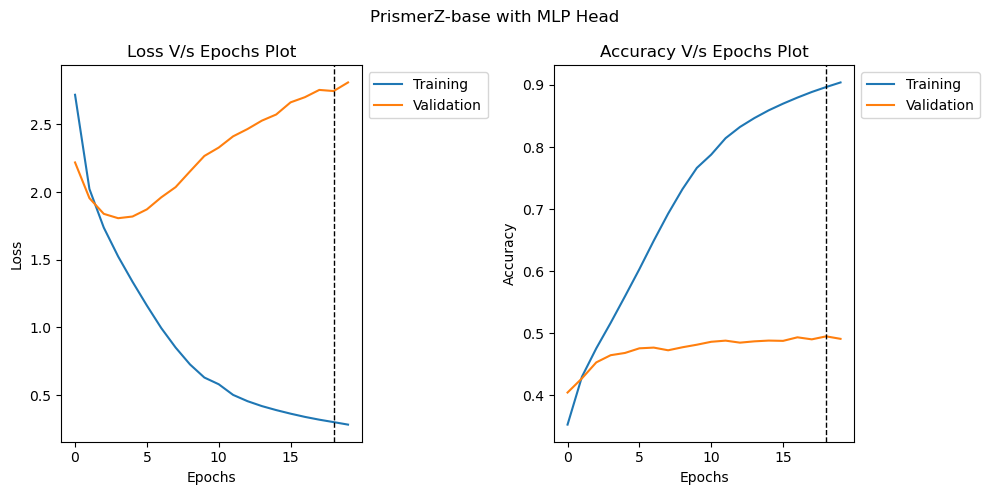

In [56]:
plotLossAcc(20, epoch_loss, epoch_acc, "PrismerZ-base with MLP Head")

## Miscellaneous

In [62]:
answers = []
for key in VQAVal.keys():
    answers.append(VQAVal[key]['answer'])

In [63]:
len(answers)

214354

'down'

In [65]:
for i in range(len(answers)):
    if not answers[i] == VQAVal[quesIDsval[i]]['answer']:
        print("No")
        break

In [66]:
_, sQuesIDs, _, _ = train_test_split(quesIDsval, answers, test_size=0.25, random_state=42)

In [67]:
len(sQuesIDs)

53589

In [68]:
fl = open('../Data/quesids.pickle', 'wb')
pickle.dump(sQuesIDs, fl)
fl.close()

In [76]:
count = 0
for name in tqdm(os.listdir('../Data/val2014Eval')):
    count += 1
print(count)

  0%|          | 0/28242 [00:00<?, ?it/s]

28242


In [73]:
dir = '../Data/val2014Eval'
for f in tqdm(os.listdir(dir)):
    os.remove(os.path.join(dir, f))

  0%|          | 0/28242 [00:00<?, ?it/s]

In [75]:
imgs = []
for qid in tqdm(sQuesIDs):
    img_id = VQAVal[qid]['image_id']
    if img_id not in imgs:
        imgs.append(img_id)
        src_path = f"../Data/val2014/{img_id}.jpg"
        dst_path =  f"../Data/val2014Eval/{img_id}.jpg"
        shutil.copy(src_path, dst_path)

  0%|          | 0/53589 [00:00<?, ?it/s]

In [ ]:
src_path = r"E:\demos\files\report\profit.txt"
dst_path = r"E:\demos\files\account\profit.txt"
shutil.copy(src_path, dst_path)
print('Copied')